In [1]:

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import warnings
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
import json

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from transformers import Wav2Vec2FeatureExtractor, HubertForSequenceClassification
warnings.filterwarnings('ignore')


/home/staru/anaconda3/envs/wave2vec/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# ============================================================================
# 1. CONFIGURATION
# ============================================================================

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 42
set_seed(SEED)

CONFIG = {
    'random_seed': SEED,
    'dataset_path': '/home/staru/audio_aug/aug_pitch_audio',
    'sr': 16000,
    'max_duration': 10.0,
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
    'batch_size': 8,
    'epochs': 30,
    'learning_rate': 2e-5,
    'max_length': 160000,
    # 'hubert_model': 'facebook/hubert-large-ls960-ft'

    'hubert_model': 'facebook/hubert-base-ls960',
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
}

EMOTIONS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Neutral']
EMOTION_TO_IDX = {emotion: idx for idx, emotion in enumerate(EMOTIONS)}
IDX_TO_EMOTION = {idx: emotion for emotion, idx in EMOTION_TO_IDX.items()}

print('✓ Configuration loaded')
print(f'  Device: {CONFIG["device"]}')
print(f'  Emotions: {EMOTIONS}')

✓ Configuration loaded
  Device: cuda
  Emotions: ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Neutral']


In [4]:

# ============================================================================
# 2. DATA LOADING
# ============================================================================

def load_audio_data(dataset_path, emotions=EMOTIONS, sr=16000, max_duration=10.0):
    """Load audio files from emotion folders."""
    file_paths = []
    stats = defaultdict(int)
    errors = []
    
    for emotion in emotions:
        emotion_dir = os.path.join(dataset_path, emotion)
        
        if not os.path.exists(emotion_dir):
            print(f'⚠ Warning: {emotion_dir} not found')
            continue
        
        audio_files = []
        for ext in ['*.mp3', '*.wav', '*.ogg', '*.flac']:
            audio_files.extend(Path(emotion_dir).glob(ext))
        
        for audio_path in audio_files:
            try:
                y, _ = librosa.load(str(audio_path), sr=sr, duration=max_duration)
                if len(y) > 0:
                    file_paths.append((str(audio_path), emotion))
                    stats[emotion] += 1
            except Exception as e:
                errors.append((str(audio_path), str(e)))
    
    print('\n✓ Dataset loaded successfully')
    print('Samples per emotion:')
    for emotion in emotions:
        count = stats.get(emotion, 0)
        print(f'  {emotion}: {count}')
    print(f'Total samples: {sum(stats.values())}')
    if errors:
        print(f'⚠ {len(errors)} files had errors')
    
    return file_paths, dict(stats)

print('Loading dataset...')
file_paths, stats = load_audio_data(CONFIG['dataset_path'])

Loading dataset...

✓ Dataset loaded successfully
Samples per emotion:
  Anger: 1350
  Disgust: 1350
  Fear: 1350
  Happy: 1350
  Sad: 1350
  Neutral: 1350
Total samples: 8100


In [5]:

# ============================================================================
# 3. STRATIFIED SPLIT
# ============================================================================

def stratified_split(file_paths, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    """Stratified split maintaining emotion distribution."""
    emotion_groups = defaultdict(list)
    for path, emotion in file_paths:
        emotion_groups[emotion].append((path, emotion))
    
    train_set, val_set, test_set = [], [], []
    np.random.seed(seed)
    
    for emotion, samples in emotion_groups.items():
        np.random.shuffle(samples)
        n_train = int(len(samples) * train_ratio)
        n_val = int(len(samples) * val_ratio)
        
        train_set.extend(samples[:n_train])
        val_set.extend(samples[n_train:n_train+n_val])
        test_set.extend(samples[n_train+n_val:])
    
    return train_set, val_set, test_set

train_set, val_set, test_set = stratified_split(file_paths, seed=SEED)

print('✓ Data split completed')
print(f'  Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}')

✓ Data split completed
  Train: 6480, Val: 810, Test: 810


In [6]:

# ============================================================================
# 4. DATASET CLASS
# ============================================================================

class EmotionAudioDataset(Dataset):
    def __init__(self, file_paths, feature_extractor, sr=16000, max_length=160000):
        self.file_paths = file_paths
        self.feature_extractor = feature_extractor
        self.sr = sr
        self.max_length = max_length
#     param.requires_grad = True 
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        audio_path, emotion = self.file_paths[idx]
        
        try:
            y, sr = librosa.load(audio_path, sr=self.sr)
            
            if len(y) < self.max_length:
                y = np.pad(y, (0, self.max_length - len(y)), mode='constant')
            else:
                y = y[:self.max_length]
            
            inputs = self.feature_extractor(
                y, sampling_rate=self.sr, return_tensors='pt', padding=True
            )
            
            return {
                'input_values': inputs['input_values'].squeeze(),
                'labels': torch.tensor(EMOTION_TO_IDX[emotion], dtype=torch.long),
                'audio_path': audio_path,
                'emotion': emotion
            }
        except Exception as e:
            print(f'Error loading {audio_path}: {e}')
            return None

def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    
    input_values = torch.stack([item['input_values'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    
    return {
        'input_values': input_values,
        'labels': labels
    }

In [7]:
# ============================================================================
# 5. LOAD MODEL (WITH FINE-TUNING)
# ============================================================================

print(f'\nLoading HuBERT model: {CONFIG["hubert_model"]}')

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(CONFIG['hubert_model'])

model = HubertForSequenceClassification.from_pretrained(
    CONFIG['hubert_model'],
    num_labels=len(EMOTIONS),
    id2label=IDX_TO_EMOTION,
    label2id=EMOTION_TO_IDX
)

# ============ FREEZE BASE MODEL (FINE-TUNING) ============
# Freeze all HuBERT layers
# for param in model.hubert.parameters():
#     param.requires_grad = False

# Only train the classifier head
# for param in model.classifier.parameters():
#     param.requires_grad = True
# =========================================================

model = model.to(CONFIG['device'])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('✓ Model loaded (FINE-TUNING MODE)')
print(f'  Total parameters: {total_params:,}')
print(f'  Trainable parameters: {trainable_params:,}')
print(f'  Frozen parameters: {total_params - trainable_params:,}')


Loading HuBERT model: facebook/hubert-base-ls960


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded (FINE-TUNING MODE)
  Total parameters: 94,570,118
  Trainable parameters: 94,570,118
  Frozen parameters: 0


In [8]:

# ============================================================================
# 6. CREATE DATA LOADERS
# ============================================================================

train_dataset = EmotionAudioDataset(train_set, feature_extractor, sr=CONFIG['sr'])
val_dataset = EmotionAudioDataset(val_set, feature_extractor, sr=CONFIG['sr'])
test_dataset = EmotionAudioDataset(test_set, feature_extractor, sr=CONFIG['sr'])

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0
) 

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn
)

print('✓ Data loaders created')
print(f'  Train batches: {len(train_loader)}')
print(f'  Val batches: {len(val_loader)}')
print(f'  Test batches: {len(test_loader)}')


✓ Data loaders created
  Train batches: 810
  Val batches: 102
  Test batches: 102


In [10]:

# ============================================================================
# 7. TRAINING SETUP
# ============================================================================

optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'])
criterion = nn.CrossEntropyLoss()

total_steps = len(train_loader) * CONFIG['epochs']
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=total_steps)

print('✓ Optimizer and scheduler configured')


✓ Optimizer and scheduler configured


In [11]:

# ============================================================================
# 8. TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, dataloader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(dataloader, desc='Training')
    for batch in pbar:
        if batch is None:
            continue
        
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_values, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        pbar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Validating'):
            if batch is None:
                continue
            
            input_values = batch['input_values'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_values, labels=labels)
            loss = outputs.loss
            
            total_loss += loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy, all_preds, all_labels


In [12]:

# ============================================================================
# 9. TRAINING LOOP
# ============================================================================

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_loss = float('inf')
patience = 5
patience_counter = 0

print('\n' + '='*60)
print('TRAINING')
print('='*60)

for epoch in range(CONFIG['epochs']):
    print(f'\nEpoch [{epoch+1}/{CONFIG["epochs"]}]')
    
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, scheduler, criterion, CONFIG['device']
    )
    
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, CONFIG['device'])
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'hubert_emotion_model_aug_pitch.pt')
        print('  ✓ Model saved')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'\n⏹ Early stopping after {epoch+1} epochs')
            break

print('\n' + '='*60)
print('✓ Training completed')



TRAINING

Epoch [1/30]


Validating: 100%|██████████| 102/102 [00:10<00:00,  9.59it/s]


  Train Loss: 1.4613 | Train Acc: 0.4198
  Val Loss: 1.1909 | Val Acc: 0.5333
  ✓ Model saved

Epoch [2/30]


Validating: 100%|██████████| 102/102 [00:10<00:00,  9.54it/s]


  Train Loss: 1.1719 | Train Acc: 0.5424
  Val Loss: 0.9882 | Val Acc: 0.6123
  ✓ Model saved

Epoch [3/30]


Validating: 100%|██████████| 102/102 [00:10<00:00,  9.61it/s]


  Train Loss: 0.9943 | Train Acc: 0.6116
  Val Loss: 0.8894 | Val Acc: 0.6679
  ✓ Model saved

Epoch [4/30]


Validating: 100%|██████████| 102/102 [00:10<00:00,  9.65it/s]


  Train Loss: 0.8731 | Train Acc: 0.6715
  Val Loss: 1.1101 | Val Acc: 0.6272

Epoch [5/30]


Validating: 100%|██████████| 102/102 [00:10<00:00,  9.75it/s]


  Train Loss: 0.7528 | Train Acc: 0.7231
  Val Loss: 0.7865 | Val Acc: 0.7420
  ✓ Model saved

Epoch [6/30]


Validating: 100%|██████████| 102/102 [00:10<00:00,  9.68it/s]


  Train Loss: 0.6158 | Train Acc: 0.7858
  Val Loss: 0.7032 | Val Acc: 0.7840
  ✓ Model saved

Epoch [7/30]


Validating: 100%|██████████| 102/102 [00:10<00:00,  9.56it/s]


  Train Loss: 0.5177 | Train Acc: 0.8307
  Val Loss: 0.7427 | Val Acc: 0.7877

Epoch [8/30]


Validating: 100%|██████████| 102/102 [00:10<00:00,  9.61it/s]


  Train Loss: 0.4590 | Train Acc: 0.8590
  Val Loss: 0.8613 | Val Acc: 0.7914

Epoch [9/30]


Validating: 100%|██████████| 102/102 [00:10<00:00,  9.70it/s]


  Train Loss: 0.4186 | Train Acc: 0.8764
  Val Loss: 0.8023 | Val Acc: 0.8272

Epoch [10/30]


Validating: 100%|██████████| 102/102 [00:10<00:00,  9.74it/s]


  Train Loss: 0.3895 | Train Acc: 0.8958
  Val Loss: 1.0390 | Val Acc: 0.7963

Epoch [11/30]


Validating: 100%|██████████| 102/102 [00:10<00:00,  9.75it/s]

  Train Loss: 0.3456 | Train Acc: 0.9093
  Val Loss: 1.0801 | Val Acc: 0.8086

⏹ Early stopping after 11 epochs

✓ Training completed


In [22]:

# ============================================================================
# 10. EVALUATION
# ============================================================================

model.load_state_dict(torch.load(
    'hubert_emotion_model_aug_pitch.pt',
    map_location=CONFIG['device']
))


test_loss, test_acc, test_preds, test_labels = validate(
    model, test_loader, criterion, CONFIG['device']
)

print('\n' + '='*60)
print('TEST RESULTS')
print('='*60)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')
print(f'\nClassification Report:\n')
print(classification_report(test_labels, test_preds, target_names=EMOTIONS))


Validating: 100%|██████████| 102/102 [00:10<00:00,  9.98it/s]


TEST RESULTS
Test Loss: 0.6897
Test Accuracy: 0.7877

Classification Report:

              precision    recall  f1-score   support

       Anger       0.97      0.84      0.90       135
     Disgust       0.62      0.68      0.65       135
        Fear       0.96      0.90      0.93       135
       Happy       0.62      0.87      0.72       135
         Sad       0.92      0.73      0.81       135
     Neutral       0.77      0.71      0.74       135

    accuracy                           0.79       810
   macro avg       0.81      0.79      0.79       810
weighted avg       0.81      0.79      0.79       810



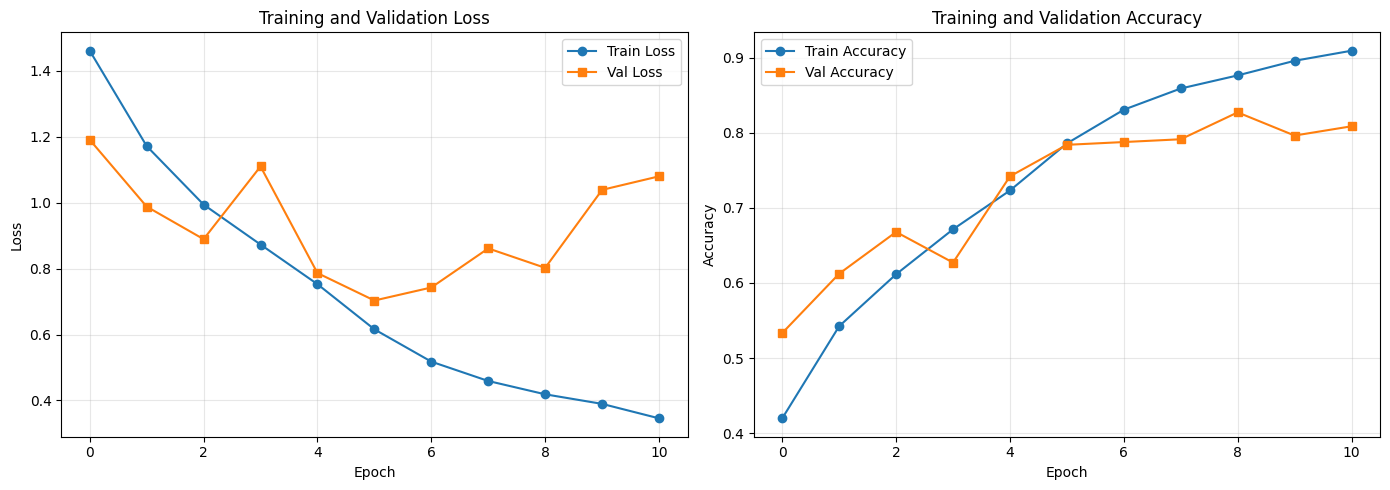

✓ Training history plot saved


In [14]:

# ============================================================================
# 11. VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hubert_training_history_pitch.png', dpi=150, bbox_inches='tight')
plt.show()

print('✓ Training history plot saved')



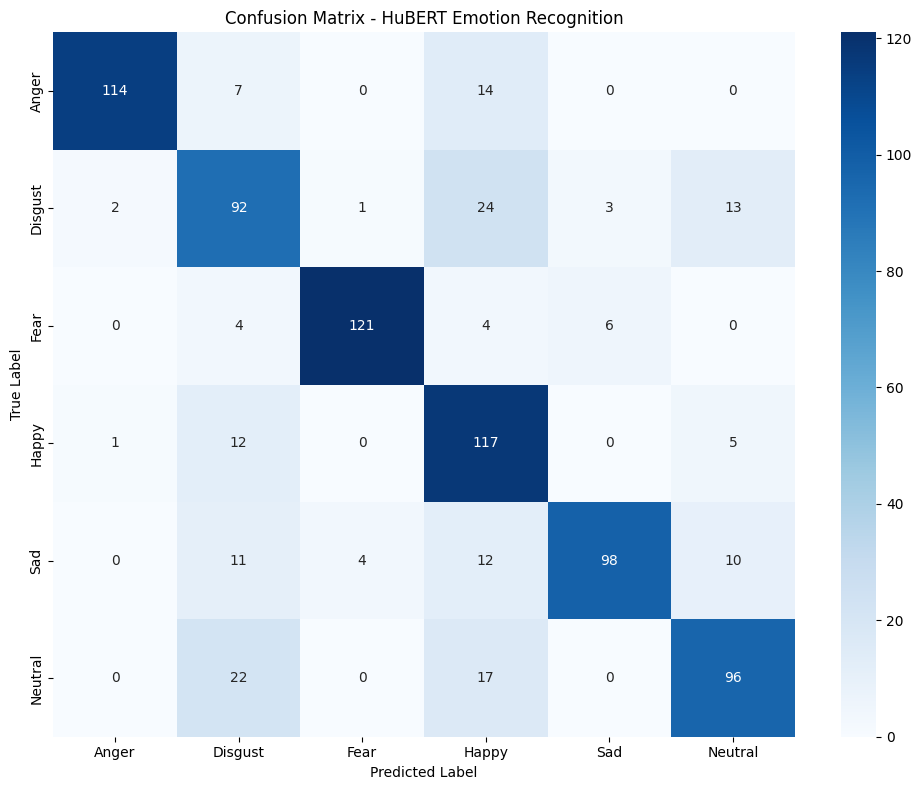

✓ Confusion matrix plot saved


In [15]:

# ============================================================================
# 12. CONFUSION MATRIX
# ============================================================================

cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.title('Confusion Matrix - HuBERT Emotion Recognition')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('hubert_confusion_matrix_pitch.png', dpi=150, bbox_inches='tight')
plt.show()

print('✓ Confusion matrix plot saved')


Per-Emotion Metrics:
Emotion  Precision   Recall  F1-Score  Support
  Anger   0.974359 0.844444  0.904762      135
Disgust   0.621622 0.681481  0.650177      135
   Fear   0.960317 0.896296  0.927203      135
  Happy   0.622340 0.866667  0.724458      135
    Sad   0.915888 0.725926  0.809917      135
Neutral   0.774194 0.711111  0.741313      135


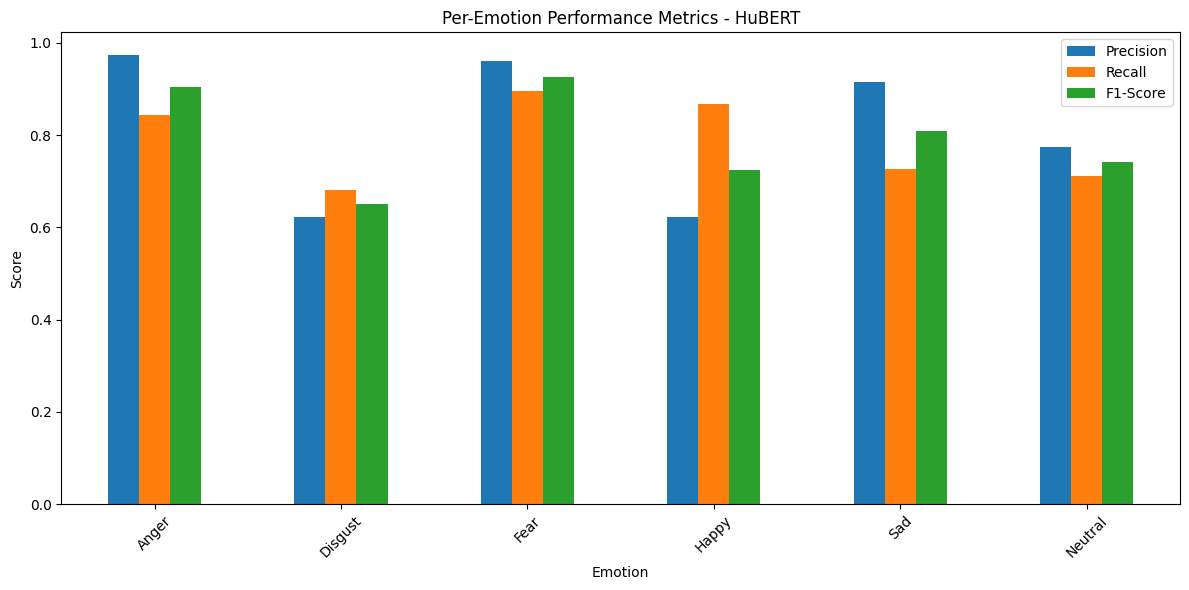

✓ Per-emotion metrics plot saved


In [16]:

# ============================================================================
# 13. PER-EMOTION METRICS
# ============================================================================

precision, recall, f1, support = precision_recall_fscore_support(
    test_labels, test_preds, labels=range(len(EMOTIONS))
)

metrics_df = pd.DataFrame({
    'Emotion': EMOTIONS,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print('\nPer-Emotion Metrics:')
print(metrics_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 6))
metrics_df.set_index('Emotion')[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', ax=ax)
plt.title('Per-Emotion Performance Metrics - HuBERT')
plt.ylabel('Score')
plt.xlabel('Emotion')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('hubert_per_emotion_metrics_pitch.png', dpi=150, bbox_inches='tight')
plt.show()

print('✓ Per-emotion metrics plot saved')


In [17]:

# ============================================================================
# 14. INFERENCE
# ============================================================================

def predict_emotion(audio_path, model, feature_extractor, device, sr=16000, max_length=160000):
    """Predict emotion for a single audio file."""
    model.eval()
    
    y, _ = librosa.load(audio_path, sr=sr)
    
    if len(y) < max_length:
        y = np.pad(y, (0, max_length - len(y)), mode='constant')
    else:
        y = y[:max_length]
    
    inputs = feature_extractor(y, sampling_rate=sr, return_tensors='pt')
    input_values = inputs['input_values'].to(device)
    
    with torch.no_grad():
        outputs = model(input_values)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predicted_id = torch.argmax(logits, dim=1).item()
        predicted_emotion = IDX_TO_EMOTION[predicted_id]
        confidence = probabilities[0, predicted_id].item()
    
    return {
        'predicted_emotion': predicted_emotion,
        'confidence': confidence,
        'probabilities': {
            EMOTIONS[i]: probabilities[0, i].item()
            for i in range(len(EMOTIONS))
        }
    }

if len(test_set) > 0:
    test_audio_path = test_set[0][0]
    true_emotion = test_set[0][1]
    
    result = predict_emotion(test_audio_path, model, feature_extractor, CONFIG['device'])
    
    print('\nExample Prediction:')
    print(f'  Audio: {os.path.basename(test_audio_path)}')
    print(f'  True Emotion: {true_emotion}')
    print(f'  Predicted Emotion: {result["predicted_emotion"]}')
    print(f'  Confidence: {result["confidence"]*100:.2f}%')
    print(f'\n  All Probabilities:')
    for emotion, prob in result['probabilities'].items():
        print(f'    {emotion}: {prob*100:.2f}%')



Example Prediction:
  Audio: A14_EN_A_S8_pitch_shift.wav
  True Emotion: Anger
  Predicted Emotion: Anger
  Confidence: 78.27%

  All Probabilities:
    Anger: 78.27%
    Disgust: 10.43%
    Fear: 0.28%
    Happy: 10.60%
    Sad: 0.12%
    Neutral: 0.30%


In [18]:
"""
# ============================================================================
# 15. SAVE RESULTS
# ============================================================================

model.save_pretrained('./hubert_emotion_model')
feature_extractor.save_pretrained('./hubert_emotion_model')

results = {
    'model': 'HuBERT',
    'config': CONFIG,
    'emotions': EMOTIONS,
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'metrics': metrics_df.to_dict(),
    'confusion_matrix': cm.tolist()
}

results['config']['device'] = str(results['config']['device'])

with open('hubert_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print('\n✓ Model and results saved successfully')
print('  - Model: ./hubert_emotion_model/')
print('  - Results: hubert_results.json')

"""

# ============================================================================
# 15. SAVE RESULTS  (HuBERT-Large + Bandpass Augmentation)
# ============================================================================

AUG_NAME = "pitch_audio"

# -------- Save model and feature extractor --------
SAVE_DIR = "./hubert_base_pitch_audio"

model.save_pretrained(SAVE_DIR)
feature_extractor.save_pretrained(SAVE_DIR)

# -------- Save experiment results --------
results = {
    'model': 'facebook/hubert-base-ls960',
    'fine_tuning_type': 'Frozen encoder + classifier only',
    'augmentation': AUG_NAME,
    'config': CONFIG,
    'emotions': EMOTIONS,
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'metrics': metrics_df.to_dict(),
    'confusion_matrix': cm.tolist(),
    'total_parameters': total_params,
    'trainable_parameters': trainable_params,
    'frozen_parameters': total_params - trainable_params
}

# Make device JSON-serializable
results['config']['device'] = str(results['config']['device'])

# -------- Save JSON file --------
RESULT_FILE = "hubert_base_pitch_audio_results.json"

with open(RESULT_FILE, 'w') as f:
    json.dump(results, f, indent=2)

print('\n✓ Model and results saved successfully')
print(f'  - Augmentation: {AUG_NAME}')
print(f'  - Model saved at: {SAVE_DIR}/')
print(f'  - Results file: {RESULT_FILE}')




✓ Model and results saved successfully
  - Augmentation: pitch_audio
  - Model saved at: ./hubert_base_pitch_audio/
  - Results file: hubert_base_pitch_audio_results.json


In [19]:
"""
# ============================================================================
# 16. SUMMARY
# ============================================================================

print('\n' + '='*60)
print('EMOTION RECOGNITION WITH HUBERT - SUMMARY')
print('='*60)
print(f'\nDataset:')
print(f'  Total samples: {len(file_paths)}')
print(f'  Train: {len(train_set)}, eatureExtractor.from_pretrained(CONFIG['hubert_model'])Val: {len(val_set)}, Test: {len(test_set)}')
print(f'\nModel:')
print(f'  Architecture: {CONFIG["hubert_model"]}')
print(f'  Total parameters: {total_params:,}')
print(f'  Trainable parameters: {trainable_params:,}')
print(f'\nResults:')
print(f'  Test Accuracy: {test_acc:.4f}')
print(f'  Test Loss: {test_loss:.4f}')
print(f'  Emotions: {EMOTIONS}')
print('='*60)

"""

# ============================================================================
# 16. SUMMARY  (HuBERT + Time Mask Augmentation)
# ============================================================================

AUG_NAME = "pitch_audio"   # <-- Change this for other augmentations

print('\n' + '='*60)
print(f'EMOTION RECOGNITION WITH HUBERT ({AUG_NAME}) - SUMMARY')
print('='*60)

print(f'\nDataset:')
print(f'  Total samples: {len(file_paths)}')
print(f'  Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}')

print(f'\nAugmentation Used:')
print(f'  Applied Augmentation: {AUG_NAME}')

print(f'\nModel:')
print(f'  Architecture: {CONFIG["hubert_model"]}')
print(f'  Total parameters: {total_params:,}')
print(f'  Trainable parameters: {trainable_params:,}')

print(f'\nResults:')
print(f'  Test Accuracy: {test_acc:.4f}')
print(f'  Test Loss: {test_loss:.4f}')
print(f'  Emotions: {EMOTIONS}')

print('='*60)



EMOTION RECOGNITION WITH HUBERT (pitch_audio) - SUMMARY

Dataset:
  Total samples: 8100
  Train: 6480, Val: 810, Test: 810

Augmentation Used:
  Applied Augmentation: pitch_audio

Model:
  Architecture: facebook/hubert-base-ls960
  Total parameters: 94,570,118
  Trainable parameters: 94,570,118

Results:
  Test Accuracy: 0.7877
  Test Loss: 0.6897
  Emotions: ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Neutral']


In [20]:
# ============================================================================
# CLEAN INFERENCE SCRIPT
# ============================================================================

from transformers import HubertForSequenceClassification, Wav2Vec2FeatureExtractor
import librosa
import torch
import numpy as np

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EMOTIONS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Neutral']
IDX_TO_EMOTION = {idx: emotion for idx, emotion in enumerate(EMOTIONS)}

# ----------------------------------------------------------------------------
# Load Model
# ----------------------------------------------------------------------------

def load_saved_model(model_path):
    model = HubertForSequenceClassification.from_pretrained(model_path)
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_path)

    model.to(DEVICE)
    model.eval()

    return model, feature_extractor


# ----------------------------------------------------------------------------
# Prediction Function
# ----------------------------------------------------------------------------

def predict_emotion(audio_path, model, feature_extractor):

    # Load audio
    y, _ = librosa.load(audio_path, sr=16000)

    # Extract features
    inputs = feature_extractor(
        y,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    input_values = inputs["input_values"].to(DEVICE)

    with torch.no_grad():
        outputs = model(input_values=input_values)
        probabilities = torch.softmax(outputs.logits, dim=1)
        predicted_id = torch.argmax(probabilities, dim=1).item()

    emotion = IDX_TO_EMOTION[predicted_id]
    confidence = probabilities[0][predicted_id].item()

    return emotion, confidence


# ----------------------------------------------------------------------------
# Example Usage
# ----------------------------------------------------------------------------
# /home/staru/Desktop/hubert_bandpass/hubert_base_bandpass
MODEL_PATH = "./hubert_base_pitch_audio"

model_loaded, extractor_loaded = load_saved_model(MODEL_PATH)

test_audio_path = test_set[0][0]  # or give direct path string
emotion, confidence = predict_emotion(
    test_audio_path,
    model_loaded,
    extractor_loaded
)

print("\nInference Result:")
print("Predicted Emotion:", emotion)
print("Confidence:", round(confidence * 100, 2), "%")



Inference Result:
Predicted Emotion: Anger
Confidence: 97.86 %
